In [1]:
import json
import numpy as np

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

In [2]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

In [3]:
with open("./units_labels.json", "r") as ul_file:
    units_labels = json.load(ul_file)

In [4]:
class DTFDEliminationResults():
    def __init__(self, data_path):
        with open(data_path, "r") as data_file:
            data = json.load(data_file)
        self.params = data['parameters']
        self.elimination_probs = data['elimination_probs']
        self.extinction_probs = data['extinction_probs']
            
    def __build_layout(self, ai_widgets):
        ai_widgets = list(ai_widgets.values())
        hbs = []
        for i in range(0, len(ai_widgets), 4):
            hb_list = [ai_widgets[i], ai_widgets[i+1]]
            if len(ai_widgets) >= i+3:
                hb_list.extend([ai_widgets[i+2], ai_widgets[i+3]])
            hbs.append(widgets.HBox(hb_list, layout=self.__get_layout()))
        return widgets.VBox(hbs, layout=self.__get_layout(vertical=True))
    
    def __build_widgets(self):
        labels = units_labels['w_labels']
        ai_widgets = {}
        for i, param in enumerate(self.params):
            fs = widgets.SelectionSlider(
                options=param['range'], value=param['range'][0], description=labels[param['name']]
            )
            ai_widgets[f'fs{i}'] = fs
            cs = widgets.Checkbox(value=False, description='Fixed')
            ai_widgets[f'cs{i}'] = cs
        return ai_widgets
    
    def __get_base_key(self, values, params):
        base_key = []
        for i, param in enumerate(self.params):
            if param in params:
                base_key.append("__param2__" if "__param1__" in base_key else "__param1__")
            else:
                base_key.append(f"{param['name']}:{values[i]}")
        return ",".join(base_key)
    
    def __get_fixed_params(self, args, verbose=False):
        params = []
        fixed = []
        values = list(args.values())
        for i in range(0, len(values), 2):
            index = int(i/2)
            if values[i + 1]:
                fixed.append(f"{self.params[index]['name']}: {values[i]}")
            else:
                params.append(self.params[index])
        if fixed and verbose:
            print(", ".join(fixed))
        return params, [param.replace(": ", ":") for param in fixed]
    
    def __get_layout(self, vertical=False):
        kwargs = {
            "margin": '0px 10px 10px 0px',
            "padding": '5px 5px 5px 5px'
        }
        if vertical:
            kwargs['border'] = 'solid 1px red'
        return widgets.Layout(**kwargs)
    
    def __get_plot_data(self, params, base_key):
        target_data = self.extinction_probs if self.plot_extinction else self.elimination_probs
        min_elim = 100
        max_elim = 0
        elimination = []
        for value1 in params[1]['range']:
            _key = base_key.replace("__param2__", f"{params[1]['name']}:{value1}")
            inner_elim = []
            for value2 in params[0]['range']:
                key = _key.replace("__param1__", "{0}:{1}".format(params[0]['name'], value2))
                inner_elim.append(target_data[key])
            if min(inner_elim) < min_elim:
                min_elim = min(inner_elim)
            if max(inner_elim) > max_elim:
                max_elim = max(inner_elim)
            elimination.append(inner_elim)
        cflip = max_elim - ((max_elim - min_elim) * 0.3)
        return np.array(elimination), cflip
    
    def __plot_elimination_param(self, res_sub_keys, key, param_label, units, save_fig=None):
        target_data = self.extinction_probs if self.plot_extinction else self.elimination_probs
        if len(self.params) < 2:
            eliminations = target_data.values()
        elif (len(self.params) - len(res_sub_keys)) != 1:
            raise Exception(f"res_sub_keys[{len(self.params)}] must be set.")
        else:
            _keys = list(target_data.keys())
            for sub_key in res_sub_keys:
                keys = []
                for res_key in _keys:
                    if sub_key in res_key.split(","):
                        keys.append(res_key)
                _keys = keys
            eliminations = [target_data[key] for key in keys]
        
        param_values = list(filter(lambda param: param['name'] == key, self.params))[0]['range']
        
        if units in ("month", "months"):
            x_ticklabels = [dates[val] for val in param_values]
        else:
            x_ticklabels = param_values
        units = "" if units is None else f" ({units})"
        fig, ax = plt.subplots(figsize=[16, 6])
        
        im = plt.plot(param_values, eliminations)
        ax.set_title(f'Dftd elimination vs. {param_label}', fontsize=14)
        ax.set_ylim(ymin=-3,ymax=103)
        ax.set_xticks(param_values)
        ax.set_xticklabels(labels=x_ticklabels)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.set_xlabel(f"{param_label}{units}", fontsize=14)
        ax.set_ylabel("DFTD elimination probability", fontsize=14)
        
        if save_fig is not None:
            plt.savefig(save_fig)
        
    def __plot_heatmap(self, params, elimination, cflip, flip_axes=False, save_fig=None, rotate_axis_labels=None):
        if not isinstance(rotate_axis_labels, list):
            rotate_axis_labels = [rotate_axis_labels]
        elif rotate_axis_labels is None:
            rotate_axis_labels = []
        
        labels = units_labels['labels']
        units = units_labels['units']
        
        unit_1 = units[params[0]['name']]
        if unit_1 in ("month", "months"):
            ticklabels_1 = [dates[val] for val in params[0]['range']]
        else:
            ticklabels_1 = params[0]['range']
        if unit_1:
            unit_1 = f" ({unit_1})"
        label_1 = f"{labels[params[0]['name']]}{unit_1}"
        
        unit_2 = units[params[1]['name']]
        if unit_2 in ("month", "months"):
            ticklabels_2 = [dates[val] for val in params[1]['range']]
        else:
            ticklabels_2 = params[1]['range']
        if unit_2:
            unit_2 = f" ({unit_2})"
        label_2 = f"{labels[params[1]['name']]}{unit_2}"
        
        if flip_axes:
            elimination = np.swapaxes(elimination, 0, 1)
        elimination = np.flip(elimination, 0)
        
        height = 2*len(elimination)
        fig, ax = plt.subplots(figsize=[16, height])

        im = ax.imshow(elimination)
        ax.set_xticks(np.arange(len(elimination[0])))
        ax.set_xticklabels(labels=ticklabels_2 if flip_axes else ticklabels_1)
        ax.set_yticks(np.arange(len(elimination)))
        ax.set_yticklabels(labels=np.flip(ticklabels_1 if flip_axes else ticklabels_2))
        ax.set_xlabel(label_2 if flip_axes else label_1, fontsize=18)
        ax.set_ylabel(label_1 if flip_axes else label_2, fontsize=18)
        
        if "X" not in rotate_axis_labels:
            ax.tick_params(axis="x", labelsize=16, labelrotation=90)
        else:
            ax.tick_params(axis="x", labelsize=16)
        if "Y" in rotate_axis_labels:
            ax.tick_params(axis="y", labelsize=16, labelrotation=90)
        else:
            ax.tick_params(axis="y", labelsize=16)
            
        ax.set_title('Probability of DFTD Elimination', fontsize=18)
        for i in range(len(elimination)):
            for j in range(len(elimination[0])):
                color = "black" if elimination[i, j] > cflip else "w"
                _ = ax.text(j, i, f"{elimination[i, j]}%", ha="center", va="center", color=color, fontsize=16)
                
        if save_fig is not None:
            plt.savefig(save_fig)

    def configure(self, **widget_args):
        if self.show_args:
            print(f"Args: {widget_args}")
            
        sim_key = []
        for i in range(0, len(widget_args), 2):
            param_key = int(i/2)
            sim_key.append(f"{self.params[param_key]['name']}:{list(widget_args.values())[i]}")
        sim_key = ",".join(sim_key)
        
        params, fixed = self.__get_fixed_params(widget_args)
        
        if len(params) < 1:
            print("There are too many fixed parameters")
        elif len(params) > 2:
            print("At least 1 fixed parameter is required")
        elif len(params) == 2:
            self.plot_heatmap(widget_args, params=params, fixed=fixed)
        else:
            self.plot_elimination_param(widget_args, params=params, fixed=fixed)
    
    def explore_results(self, plot_extinction=False, show_args=False):
        self.plot_extinction = plot_extinction
        self.show_args = show_args
        
        ai_widgets = self.__build_widgets()
        ui = self.__build_layout(ai_widgets)
        out = interactive_output(self.configure, ai_widgets)
        display(ui, out)
        
    def plot_heatmap(self, args, params=None, fixed=None, flip_axes=False, save_fig=None, rotate_axis_labels=None):
        if params is None or fixed is None:
            params, fixed = self.__get_fixed_params(args)
            
        base_key = self.__get_base_key(list(args.values())[::2], params)
        elimination, cflip = self.__get_plot_data(params, base_key)
        self.__plot_heatmap(params, elimination, cflip, flip_axes=flip_axes, save_fig=save_fig, rotate_axis_labels=rotate_axis_labels)
        
    def plot_elimination_param(self, args, params=None, fixed=None, save_fig=None):
        if params is None or fixed is None:
            params, fixed = self.__get_fixed_params(args)
            
        labels = units_labels['labels']
        units = units_labels['units']
        param = params[0]
        self.__plot_elimination_param(
            res_sub_keys=fixed, key=param['name'], param_label=labels[param['name']],
            units=units[param['name']],
            save_fig=save_fig
        )

# Explore DFTD Elimination or Devil Extinction results
To explore Devil Extinction results:
- set `plot_extinction=True` in `DTFDEliminationResults.explore_results`

To save plot figures:
- set `show_args=True` in `DTFDEliminationResults.explore_results`
- copy args and pass to:
  - `DTFDEliminationResults.plot_heatmap` for heatmaps
  - `DTFDEliminationResults.plot_elimination_param` for trace plots
- set `save_fig=filename` in the chosen plot function where the filename name is the name of your choice

Options:
- setting `flip_axes=True` in `DTFDEliminationResults.plot_heatmap` will flip the X and Y axes.
- setting `rotate_axis_labels` will have the following effects:
  - `rotate_axis_labels="X"` will rotate the X-Axis labels by 90 degrees
  - `rotate_axis_labels="Y"` will rotate the Y-Axis labels by 90 degrees
  - `rotate_axis_labels=["X", "Y"]` will rotate the X- and Y-Axis labels by 90 degrees

Example:
```
immunity_path = "./DevilsDFTD2StageInfectionWithImmunity.json"
immunity_res = DTFDEliminationResults(immunity_path)
immunity_res.explore_results(show_args=True)

Args: {'fs0': 0.005, 'cs0': False, 'fs1': 50, 'cs1': False, 'fs2': 384, 'cs2': True}

immunity_res.plot_heatmap(
    args={'fs0': 0.005, 'cs0': False, 'fs1': 50, 'cs1': False, 'fs2': 384, 'cs2': True},
    save_fig="figure.pdf"
)
```

In [5]:
immunity_path = "./DevilsDFTD2StageInfectionWithImmunity.json"
immunity_res = DTFDEliminationResults(immunity_path)
immunity_res.explore_results(show_args=True)

Output()

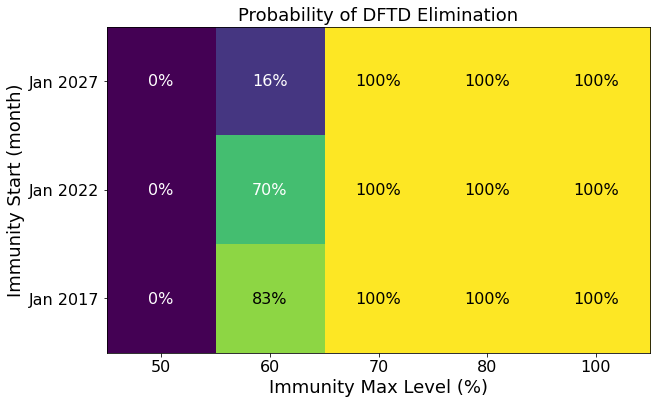

In [6]:
immunity_res.plot_heatmap(
    args={'fs0': 0.0075, 'cs0': True, 'fs1': 50, 'cs1': False, 'fs2': 444, 'cs2': False},
    rotate_axis_labels="X", save_fig="../figures/sec4.2.3_immunity_heatmap.pdf"
)

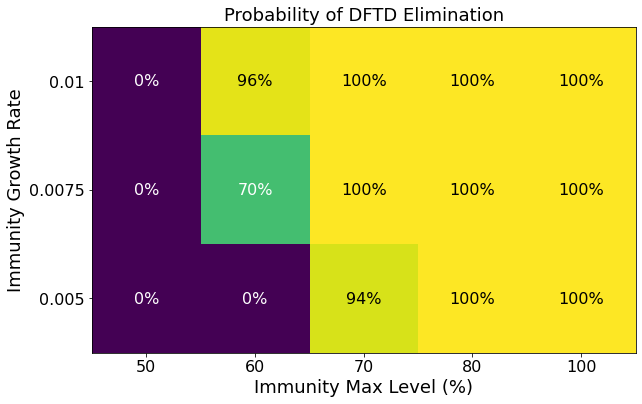

In [7]:
immunity_res.plot_heatmap(
    args={'fs0': 0.0075, 'cs0': False, 'fs1': 50, 'cs1': False, 'fs2': 444, 'cs2': True},
    flip_axes=True, rotate_axis_labels="X", save_fig="../figures/sec4.2.3_immunity_heatmap_b.pdf"
)

In [8]:
vaccination_path = "./DevilsDFTD2StageInfectionWithVaccination.json"
vaccination_res = DTFDEliminationResults(vaccination_path)
vaccination_res.explore_results(show_args=True)

Output()

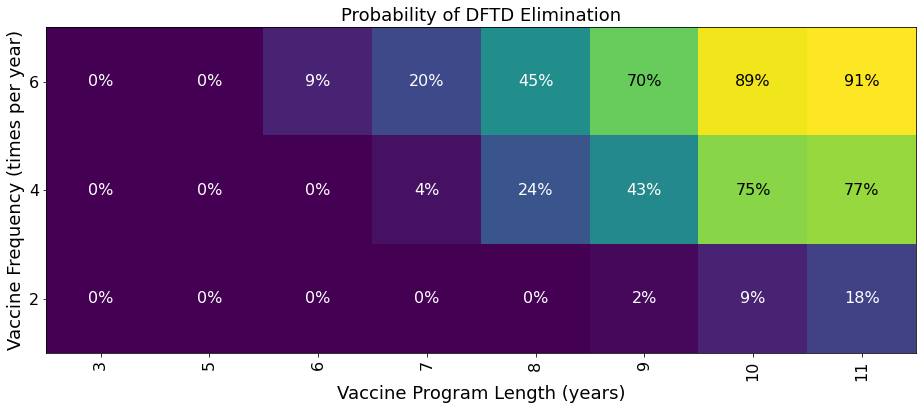

In [9]:
vaccination_res.plot_heatmap(
    args={'fs0': 0.1, 'cs0': True, 'fs1': 0.8, 'cs1': True, 'fs2': 3, 'cs2': False, 'fs3': 2, 'cs3': False},
#     save_fig="../figures/sec4.2.1a_vaccination_heatmap_fxl.pdf"
)

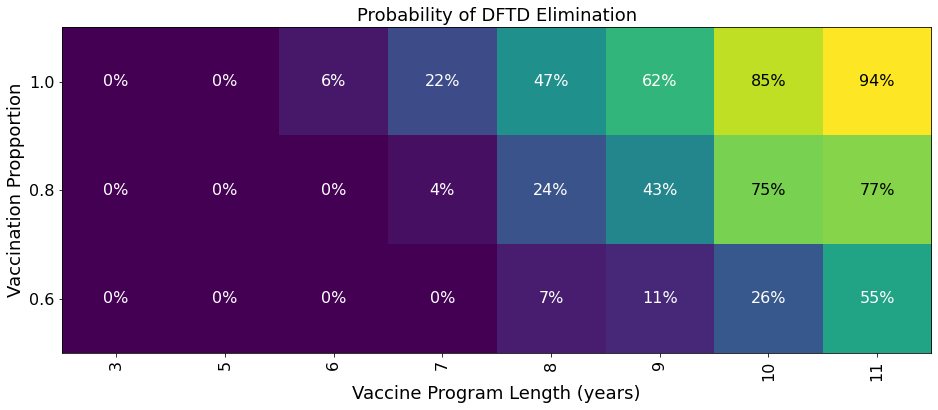

In [10]:
vaccination_res.plot_heatmap(
    args={'fs0': 0.1, 'cs0': True, 'fs1': 0.6, 'cs1': False, 'fs2': 3, 'cs2': False, 'fs3': 4, 'cs3': True},
    flip_axes=True#, save_fig="../figures/sec4.2.1b_vaccination_heatmap_pxl.pdf"
)

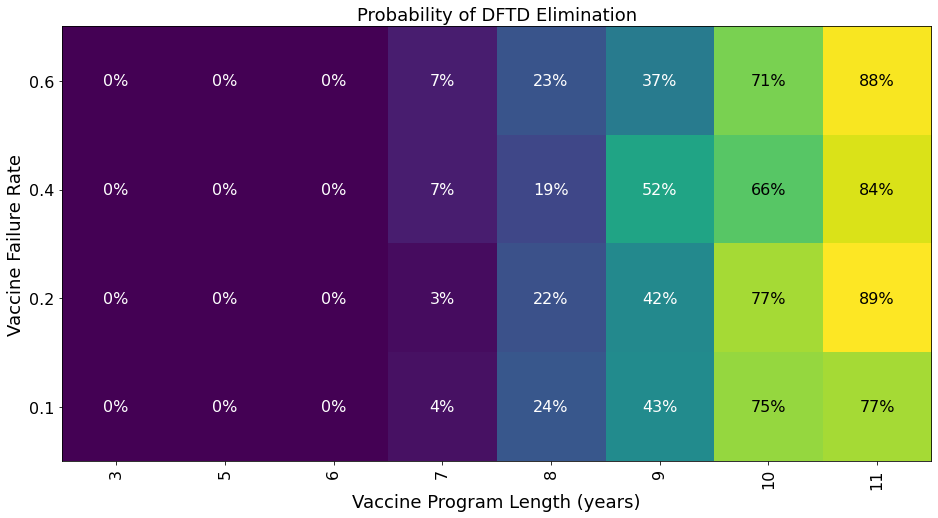

In [11]:
vaccination_res.plot_heatmap(
    args={'fs0': 0.1, 'cs0': False, 'fs1': 0.8, 'cs1': True, 'fs2': 3, 'cs2': False, 'fs3': 4, 'cs3': True},
    flip_axes=True#, save_fig="../figures/sec4.2.1c_vaccination_heatmap_pxl.pdf"
)

In [12]:
culling_path = "./DevilsDFTD2StageInfectionWithCulling.json"
culling_res = DTFDEliminationResults(culling_path)
culling_res.explore_results(show_args=True)

Output()

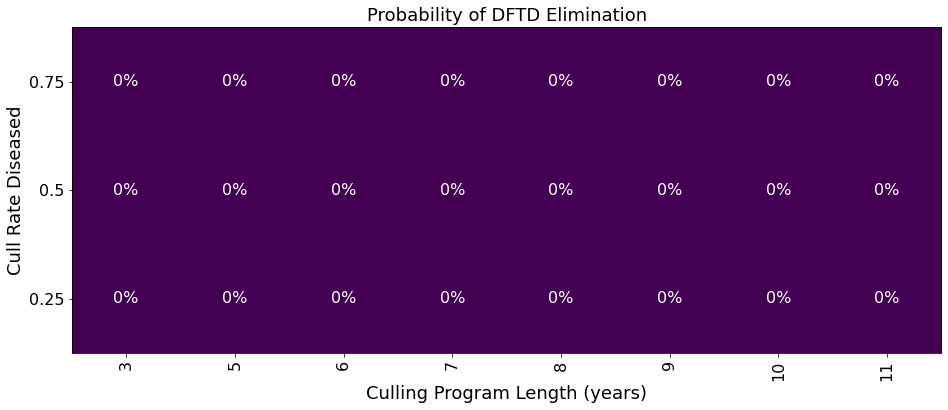

In [13]:
culling_res.plot_heatmap(
    args={'fs0': 0.25, 'cs0': False, 'fs1': 3, 'cs1': False},
    flip_axes=True#, save_fig="../figures/sec4.2.2_culling_heatmap.pdf"
)

In [14]:
try:
    immun_vacc_path = "./DevilsDFTD2StageInfectionWithImmunityAndVaccination.json"
    immun_vacc_res = DTFDEliminationResults(immun_vacc_path)
    immun_vacc_res.explore_results()
except:
    print("Data for Immunity + Vaccination is not currently available.")

Output()

In [15]:
try:
    immun_cull_path = "./DevilsDFTD2StageInfectionWithImmunityAndCulling.json"
    immun_cull_res = DTFDEliminationResults(immun_cull_path)
    immun_cull_res.explore_results()
except:
    print("Data for Immunity + Culling is not currently available.")

Output()

In [18]:
try:
    vacc_cull_path = "./DevilsDFTD2StageInfectionWithVaccinationAndCulling.json"
    vacc_cull_res = DTFDEliminationResults(vacc_cull_path)
    vacc_cull_res.explore_results(show_args=True)
except:
    print("Data for Vaccination + Culling is not currently available.")

Output()

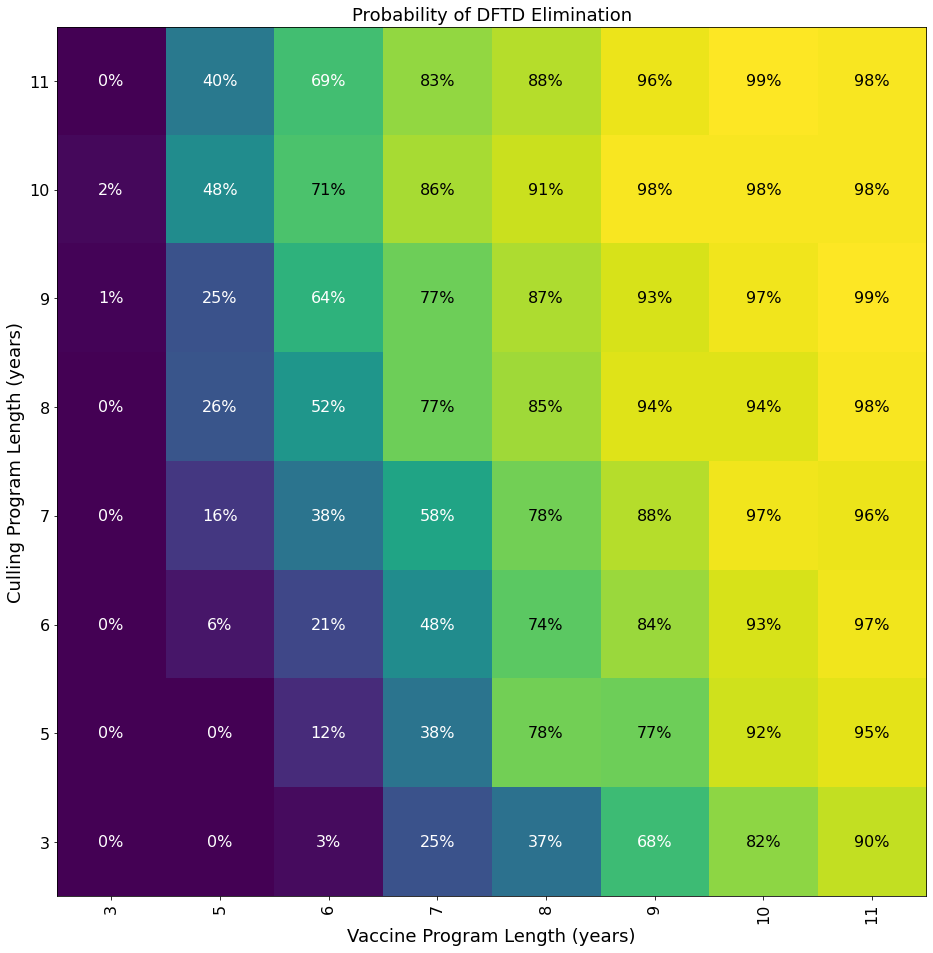

In [22]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': True, 'fs2': 3, 'cs2': False, 'fs3': 4, 'cs3': True, 'fs4': 0.5, 'cs4': True, 'fs5': 3, 'cs5': False},
    flip_axes=False
    , save_fig="../figures/sec4_vacc_cull_heatmap_a.pdf"
)

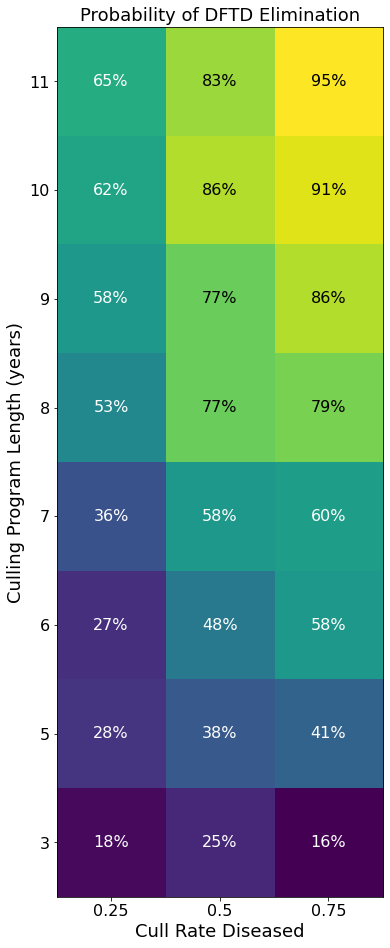

In [32]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': True, 'fs2': 7, 'cs2': True, 'fs3': 4, 'cs3': True, 'fs4': 0.5, 'cs4': False, 'fs5': 3, 'cs5': False}
    ,flip_axes=False
    ,rotate_axis_labels="X"
    , save_fig="../figures/sec4_vacc_cull_heatmap_b.pdf"
)

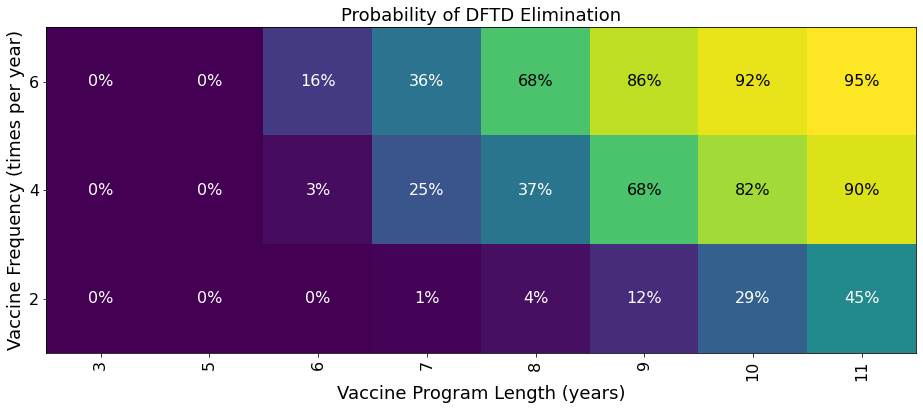

In [25]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': True, 'fs2': 7, 'cs2': False, 'fs3': 4, 'cs3': False, 'fs4': 0.5, 'cs4': True, 'fs5': 3, 'cs5': True}
    ,flip_axes=False
    , save_fig="../figures/sec4_vacc_cull_heatmap_c.pdf"
)

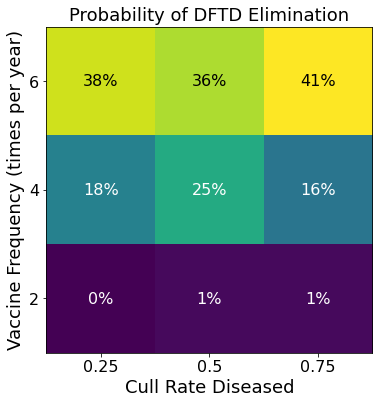

In [33]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': True, 'fs2': 7, 'cs2': True, 'fs3': 4, 'cs3': False, 'fs4': 0.5, 'cs4': False, 'fs5': 3, 'cs5': True}
    ,flip_axes=True
    ,rotate_axis_labels="X"
    , save_fig="../figures/sec4_vacc_cull_heatmap_d.pdf"
)



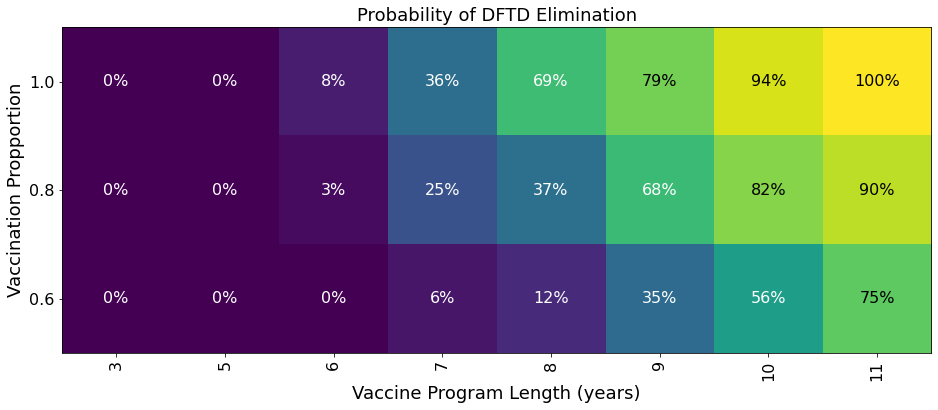

In [36]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': False, 'fs2': 7, 'cs2': False, 'fs3': 4, 'cs3': True, 'fs4': 0.5, 'cs4': True, 'fs5': 3, 'cs5': True}
    ,flip_axes=True
    , save_fig="../figures/sec4_vacc_cull_heatmap_e.pdf"
)

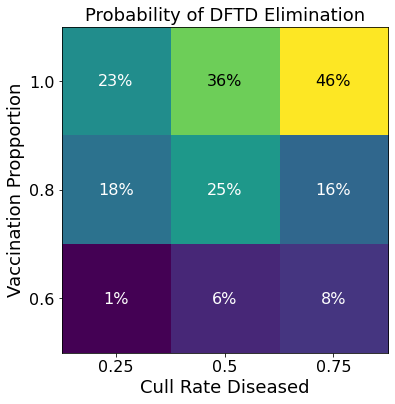

In [34]:
vacc_cull_res.plot_heatmap(
    args={'fs0': 0.4, 'cs0': True, 'fs1': 0.8, 'cs1': False, 'fs2': 7, 'cs2': True, 'fs3': 4, 'cs3': True, 'fs4': 0.5, 'cs4': False, 'fs5': 3, 'cs5': True}
    ,flip_axes=True
    ,rotate_axis_labels="X"
    , save_fig="../figures/sec4_vacc_cull_heatmap_f.pdf"
)


In [17]:
try:
    immun_vacc_cull_path = "./DevilsDFTD2StageInfectionWithImmunityVaccinationCulling.json"
    immun_vacc_cull_res = DTFDEliminationResults(immun_vacc_cull_path)
    immun_vacc_cull_res.explore_results()
except:
    print("Data for Immunity + Vaccination + Culling is not currently available.")

Data for Immunity + Vaccination + Culling is not currently available.
